# Spiker 

Classic Hodgkin-Huxely-based Spiker model.

In [ ]:
# Set the path
import sys
sys.path.append("../../")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.act_types import SimulationParameters, ConstantCurrentInjection, FilterParameters, ConductanceOptions, OptimizationParameters
from act.data_processing import ACTDataProcessor as dp
from act.act_module import ACTModule, ACTModuleParameters

import numpy as np
import matplotlib.pyplot as plt

from act.passive import ACTPassiveModule
from act.segregation import ACTSegregator

from sklearn.metrics import mean_absolute_error
from act.metrics import pp_error

## 1. Set the "target" model and simulate from it

The "target" model's output represents the target bio data provided by the user to tune for.

Parameters:
- Cm = 1
- gnabar = .12 (S/cm2)
- gkbar = .036 (S/cm2)
- gl = .0003 (S/cm2)
- el = -54.3 (mV)

In [4]:
# Define the "target" cell
target_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [5]:
target_g = np.array([0.0003, 0.12, 0.036])

### 1.1. Target passive properties

In [6]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "target",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100, lto_hto = 0)])

simulator.submit_job(target_cell, sim_params)
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


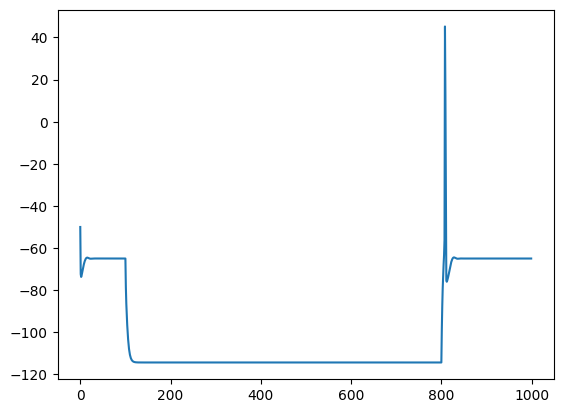

In [7]:
passive_trace = np.load("output/target/out_0.npy")[:, 0]
plt.plot(passive_trace[::10])

In [8]:
target_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
target_gpp

GettablePassiveProperties(R_in=246.82388046911376, tau1=4.1000000000000005, tau2=544.9, sag_ratio=0.0, V_rest=-64.97367898269046)

### 1.2. Target FI curve

In [9]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "target",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100, lto_hto = 0)])

    simulator.submit_job(target_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/target")


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/target


Text(0, 0.5, 'Voltage (mV)')

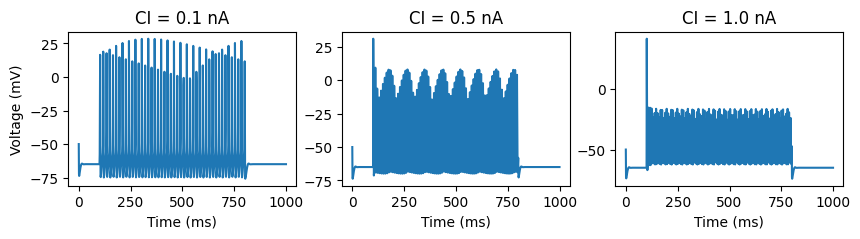

In [10]:
# Plot the traces and the FI curve
simulated_data = np.load("output/target/combined_out.npy") # 3 x 10000 x 4; (n_sim x time x [V, I, g, lto_hto])

fig, ax = plt.subplots(1, 3, figsize = (10, 2))
for axid, amp in enumerate([0.1, 0.5, 1.0]):
    ax[axid].plot(simulated_data[axid, ::10, 0])
    ax[axid].set_xlabel("Time (ms)")
    ax[axid].set_title(f"CI = {amp} nA")

ax[0].set_ylabel("Voltage (mV)")

In [11]:
target_frequencies = dp.get_fi_curve(
    simulated_data[:, ::10, 0],
    -30,
    [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0),
    ]
)

Text(0.5, 1.0, 'FI Curve')

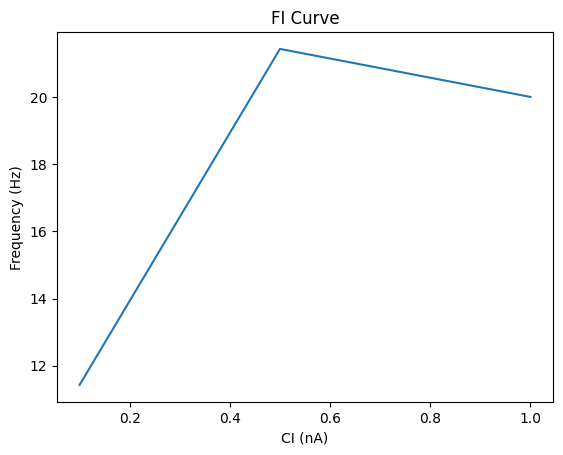

In [12]:
plt.plot([0.1, 0.5, 1.0], target_frequencies)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

## 2. Original pipeline - optimize passive and active channels together

### 2.1. Set the train cell 

We assume the train cell was acquired from an external source, e.g., AllenDB. Thus, its parameters do not necesserily match those of the target cell. Here we set these parameters to the target's values +- 10% std.

In [13]:
random_state = np.random.RandomState(123)
target_values = np.array([1, 0.12, 0.036, 0.0003, -54.3]) # Cm, gnabar, gkbar, gl, el
target_values = target_values + random_state.normal(0, np.abs(target_values * 0.1))
target_values

array([ 8.91436940e-01,  1.31968145e-01,  3.70187226e-02,  2.54811159e-04,
       -5.74417994e+01])

Train cell (updated in template.hoc):

- Cm = 0.89
- gnabar = 0.132 (S/cm2)
- gkbar = 0.037 (S/cm2)
- gl = 0.00025 (S/cm2)
- el = -57.4 (mV)

In [14]:
# Define the train cell
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

### 2.2. Passive properties before tuning

In [15]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "orig",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100, lto_hto = 0)])

simulator.submit_job(train_cell, sim_params)
simulator.run_jobs(1)

passive_trace = np.load("output/orig/out_0.npy")[:, 0]
ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


GettablePassiveProperties(R_in=315.86372513098706, tau1=4.4, tau2=543.6, sag_ratio=0.0, V_rest=-66.27239858673221)

### 2.3. FI curve before tuning

In [16]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "orig",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100, lto_hto = 0)])

    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/orig")


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/orig


Text(0.5, 1.0, 'FI Curve')

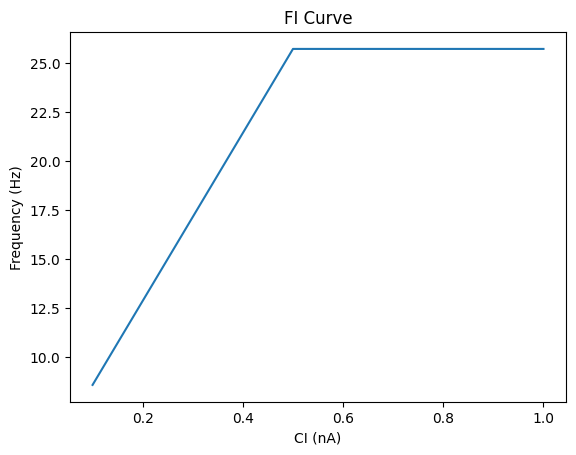

In [17]:
simulated_data = np.load("output/orig/combined_out.npy")

frequencies = dp.get_fi_curve(
    simulated_data[:, ::10, 0],
    -30,
    [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0),
    ]
)

plt.plot([0.1, 0.5, 1.0], frequencies)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

### 2.4 Optimize

In [18]:
# Parameter ranges as if provided by the user
gbar_leak = 0.00025
gbar_na = 0.132
gbar_kdr = 0.037

random_state = np.random.RandomState(123)
gbar_leak_range = (gbar_leak - random_state.uniform(0, gbar_leak / 2), gbar_leak + random_state.uniform(0, gbar_leak / 2))
gbar_na_range = (gbar_na - random_state.uniform(0, gbar_na / 2), gbar_na + random_state.uniform(0, gbar_na / 2))
gbar_kdr_range = (gbar_kdr - random_state.uniform(0, gbar_kdr / 2), gbar_kdr + random_state.uniform(0, gbar_kdr / 2))

print(f"Leak: {gbar_leak_range}")
print(f"Na: {gbar_na_range}")
print(f"Kdr: {gbar_kdr_range}")

Leak: (0.0001629413518002673, 0.00028576741686879743)
Na: (0.1170278040647626, 0.16838677475947084)
Kdr: (0.02368982405896708, 0.04482746951230253)


In [20]:
# Possibly adjsut
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gl", "hh_spiker.gnabar", "hh_spiker.gkbar"], # "Trick" to optimize for g_leak too
)

In [ ]:
sim_params = SimulationParameters(
    sim_name = "spiker_orig_train",
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
          ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
          ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0)])

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gl", low = gbar_leak_range[0], high = gbar_leak_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = gbar_na_range[0], high = gbar_na_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = gbar_kdr_range[0], high = gbar_kdr_range[1], n_slices = 3),  
    ],
    train_features = None,
    prediction_eval_method = 'fi_curve',
    spike_threshold = 0,
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    ),
    first_n_spikes = 20,
    random_state = 123,
    save_file = f"output/spiker_orig/results/saved_metrics.json"
)

original_module = ACTModule(
    ACTModuleParameters(
        module_folder_name = "output/spiker_orig",
        cell = train_cell,
        target_traces_file = f"output/target/combined_out.npy",
        sim_params = sim_params,
        optim_params = optim_params
    )
)

In [22]:
predicted_g_data_file = original_module.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA

        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/Users/vladimiromelyusik/ACT/experiments/Spiker/output/spiker_orig/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Num Troughs', 'Trough Time 1', 'Trough Time 2', 'Trough Time 3', 'Trough Time 4', 'Trough Time 5', 'Trough Time 6', 'Trough Time 7', 'Trough Time 8', 'Trough Time 9', 'Trough Time 10', 'Trough Time 11', 'Trough Time 12', '

In [23]:
orig_g = [0.00016294135180026554, 0.11702780406476183, 0.02368982405896694]

In [28]:
mean_absolute_error(target_g, orig_g)

0.005139810174823651

### 2.5. Passive properties after tuning

In [24]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [25]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "spiker_orig_after",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    set_g_to = [],
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100, lto_hto = 0)])

train_cell.set_g_bar(["hh_spiker.gl", "hh_spiker.gnabar", "hh_spiker.gkbar"], orig_g, sim_params)

simulator.submit_job(train_cell, sim_params)
simulator.run_jobs(1)

passive_trace = np.load("output/spiker_orig_after/out_0.npy")[:, 0]
ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


GettablePassiveProperties(R_in=510.7221919274452, tau1=6.2, tau2=520.8000000000001, sag_ratio=0.0, V_rest=-65.79346847725724)

In [26]:
orig_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
orig_gpp

GettablePassiveProperties(R_in=510.7221919274452, tau1=6.2, tau2=520.8000000000001, sag_ratio=0.0, V_rest=-65.79346847725724)

In [29]:
pp_error(target_gpp, orig_gpp)

[('R_in', 263.8983114583314),
 ('tau1', 2.0999999999999996),
 ('tau2', 24.09999999999991),
 ('sag_ratio', 0.0),
 ('V_rest', 0.819789494566777)]

### 2.6. FI curve after tuning

In [30]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [31]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")


for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "spiker_orig_after",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100, lto_hto = 0)],
        set_g_to = [])
    
    train_cell.set_g_bar(
        ["hh_spiker.gl", "hh_spiker.gnabar", "hh_spiker.gkbar"], 
        orig_g, 
        sim_params)


    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/spiker_orig_after")


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/spiker_orig_after


Text(0.5, 1.0, 'FI Curve')

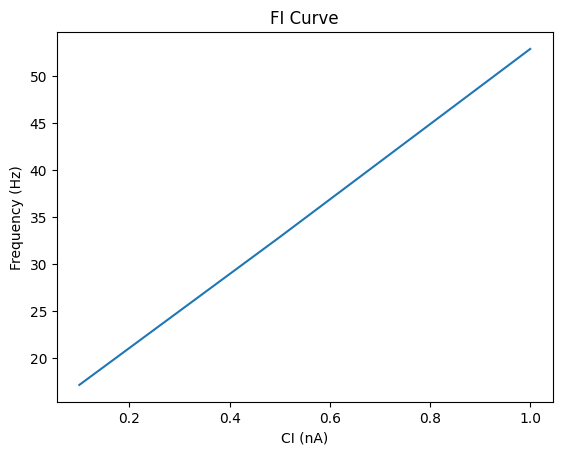

In [52]:
simulated_data = np.load("output/spiker_orig_after/combined_out.npy")

orig_frequencies = dp.get_fi_curve(
    simulated_data[:, ::10, 0],
    -30,
    [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0),
    ]
)

plt.plot([0.1, 0.5, 1.0], orig_frequencies)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

In [53]:
mean_absolute_error(target_frequencies, orig_frequencies)

16.666666666666668

## 3. Segregated pipeline

### 3.1. Segregate channels into functional modules

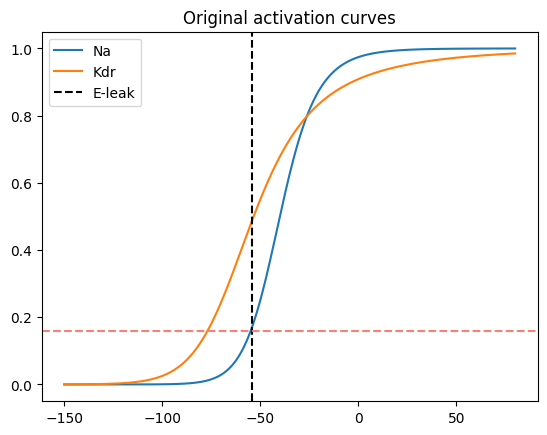

In [33]:
# From ACT/data/Spiker/orig/modfiles/hh.mod
def vtrap(x,y):
    if np.any(np.abs(x/y) < 1e-6):
        vtrap = y * (1 - x/y/2)
    else:
        vtrap = x / (np.exp(x/y) - 1)
    return vtrap

def Na(v):
    aNa = 0.1 * vtrap(-(v + 40), 10)
    bNa =  4 * np.exp(-(v + 65) / 18)
    return aNa / (aNa + bNa)

def Kdr(v):
    aK = 0.01 * vtrap(-(v + 55),10)
    bK = 0.125 * np.exp(-(v + 65) / 80)
    return aK / (aK + bK)

v = np.linspace(-150, 80, 1000)

plt.plot(v, Na(v), label = 'Na')
plt.plot(v, Kdr(v), label = 'Kdr')
plt.title("Original activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [34]:
segregator = ACTSegregator()
seg_Na, seg_Kdr = segregator.segregate(v = v, activation_curves = [Na(v), Kdr(v)], v_rest = -65, dv_from_rest = 2)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -61) {
        replace_with_var_name = 0.041 * v + 2.602
        }
        if (v < -63) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -61) {
        replace_with_var_name = 0.189 * v + 11.915
        }
        if (v < -63) {
        replace_with_var_name = 0
        }
        


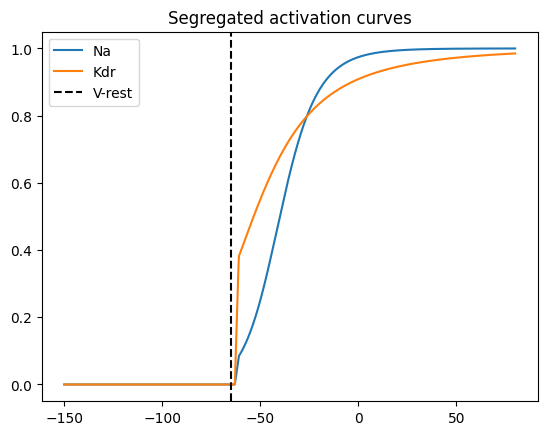

In [35]:
plt.plot(v, seg_Na, label = 'Na')
plt.plot(v, seg_Kdr, label = 'Kdr')
plt.title("Segregated activation curves")
plt.axvline(-65, color = 'black', ls = '--', label = "V-rest")
plt.legend()

### 3.2. Run the passive module

In [36]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [37]:
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "spiker_dummy",
    sim_idx = 0,
    h_tstop = 10,
    CI = []
    )

simulator.run(train_cell, sim_params)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
Soma area: 1110.3645074847766
Soma diam: 18.8
Soma L: 18.8


In [38]:
user_provided_Rin = 246.82388046911376 * 1e6 # (Ohm) 
computed_soma_area = 1110.3645074847766 * 1e-8 # pi * diam * L + pi * diam^2 / 2 ; (cm2)
user_provided_tau = 4.1000000000000005 * 1e-3 # (sec)
user_provided_Vrest = -64.97367898269046 # (mV)

ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)

SettablePassiveProperties(Cm=1.4959983332281186, g_bar_leak=0.0003648776422507606, e_rev_leak=-64.97367898269046, g_bar_h=None)

**NOTE:** adjust these in the hoc file manually.

In [40]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "seg",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100, lto_hto = 0)])

simulator.submit_job(train_cell, sim_params)
simulator.run_jobs(1)

passive_trace = np.load("output/seg/out_0.npy")[:, 0]
seg_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
seg_gpp


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


GettablePassiveProperties(R_in=246.74113850695056, tau1=4.3, tau2=564.3000000000001, sag_ratio=0.0, V_rest=-65.00000000094045)

In [41]:
pp_error(target_gpp, seg_gpp)

[('R_in', 0.08274196216319751),
 ('tau1', 0.1999999999999993),
 ('tau2', 19.40000000000009),
 ('sag_ratio', 0.0),
 ('V_rest', 0.02632101824998756)]

### 3.3. Optimize active channels

In [42]:
# Parameter ranges as if provided by the user
gbar_leak = 0.00025
gbar_na = 0.132
gbar_kdr = 0.037

random_state = np.random.RandomState(123)
gbar_leak_range = (gbar_leak - random_state.uniform(0, gbar_leak / 2), gbar_leak + random_state.uniform(0, gbar_leak / 2))
gbar_na_range = (gbar_na - random_state.uniform(0, gbar_na / 2), gbar_na + random_state.uniform(0, gbar_na / 2))
gbar_kdr_range = (gbar_kdr - random_state.uniform(0, gbar_kdr / 2), gbar_kdr + random_state.uniform(0, gbar_kdr / 2))

print(f"Leak: {gbar_leak_range}")
print(f"Na: {gbar_na_range}")
print(f"Kdr: {gbar_kdr_range}")

Leak: (0.0001629413518002673, 0.00028576741686879743)
Na: (0.1170278040647626, 0.16838677475947084)
Kdr: (0.02368982405896708, 0.04482746951230253)


In [43]:
# Possibly adjsut
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [44]:
sim_params = SimulationParameters(
    sim_name = "spiker_seg_train",
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
          ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
          ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0)])

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = gbar_na_range[0], high = gbar_na_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = gbar_kdr_range[0], high = gbar_kdr_range[1], n_slices = 3),  
    ],
    train_features = 
    ["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "number_of_troughs", "trough_times", "trough_height_stats"],
    prediction_eval_method = 'fi_curve',
    spike_threshold = 0,
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    ),
    first_n_spikes = 20,
    random_state = 123,
    save_file = f"output/spiker_seg/results/saved_metrics.json"
)

spiking_module = ACTModule(
    ACTModuleParameters(
        module_folder_name = "output/spiker_seg",
        cell = train_cell,
        target_traces_file = f"output/target/combined_out.npy",
        sim_params = sim_params,
        optim_params = optim_params
    )
)

In [45]:
predicted_g_data_file = spiking_module.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA

        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/Users/vladimiromelyusik/ACT/experiments/Spiker/output/spiker_seg/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Num Troughs', 'Trough Time 1', 'Trough Time 2', 'Trough Time 3', 'Trough Time 4', 'Trough Time 5', 'Trough Time 6', 'Trough Time 7', 'Trough Time 8', 'Trough Time 9', 'Trough Time 10', 'Trough Time 11', 'Trough Time 12', 'T

In [47]:
seg_g = np.array([0.0003648776422507606, 0.11702780406476183, 0.02368982405896694])
mean_absolute_error(target_g, seg_g)

0.005115749839507327

### 3.4. FI curve after optimization

In [48]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [49]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")


for sim_idx, amp_value in enumerate([0.1, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "spiker_seg_after",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100, lto_hto = 0)],
        set_g_to = [])
    
    train_cell.set_g_bar(
        ["hh_spiker.gnabar", "hh_spiker.gkbar"], 
        seg_g[1:], 
        sim_params)


    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/spiker_seg_after")


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/spiker_seg_after


Text(0.5, 1.0, 'FI Curve')

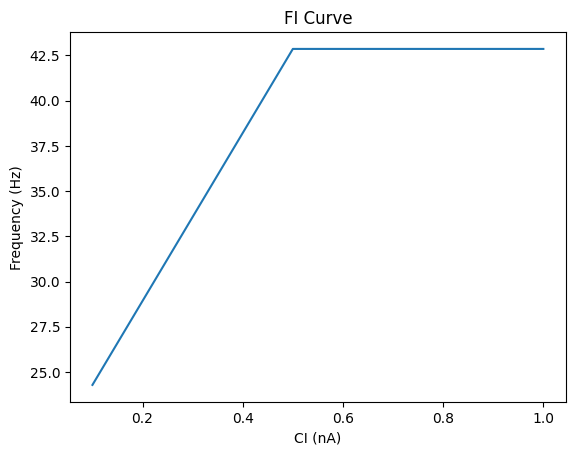

In [50]:
simulated_data = np.load("output/spiker_seg_after/combined_out.npy")

seg_frequencies = dp.get_fi_curve(
    simulated_data[:, ::10, 0],
    -30,
    [ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
     ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100, lto_hto = 0),
    ]
)

plt.plot([0.1, 0.5, 1.0], seg_frequencies)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

In [51]:
mean_absolute_error(target_frequencies, seg_frequencies)

19.04761904761905